## Imports

In [1]:
import pickle
import gzip
import os
import time
import copy
import cv2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## Utility Functions

In [4]:
def print_train_data_point(item, verbose=False):
    name = item['name']   #
    video = item['video'] #
    box = item['box']
    label = item['label']
    frames = item['frames'] #
    dataset = item['dataset'] #
    
    print(f"Dataset: {dataset}, Name: {name}\nVideo Shape:   {video.shape}\nLabeld Frames: {frames}")
    if verbose:
        print(f"Box Shape:   {box.shape}\nLabel Shape: {label.shape}")
    print()
    
def resize_boolean_array(b_item, shape=(256, 256)):
    # Step 1: Convert boolean to uint8 (True -> 255, False -> 0)
    b_item_uint8 = b_item.astype(np.uint8) * 255
    
    # Step 2: Resize the array with nearest-neighbor interpolation
    size = (shape[1],shape[0])
    resized_item = cv2.resize(b_item_uint8, size, interpolation=cv2.INTER_NEAREST)
    
    # Step 3: Convert back to boolean (any value >= 127 is True)
    resized_item_boolean = resized_item >= 127
    
    return resized_item_boolean

def extract_box_center_batch(boolean_batch):
    
    batch_size = boolean_batch.shape[0]
    coordinates = []
    
    for i in range(batch_size):
        boolean_array = boolean_batch[i]
        height, width = boolean_array.shape
        #print(boolean_array)
        
        x1 = None
        y1 = None
        x2 = None
        y2 = None
        i = 0
        
        for h in range(height):
            for w in range(width):
                if boolean_array[h][w] == True:
                    x2, y2 = h, w
                    if (i==0):
                        x1, y1 = h, w
                    i += 1
        
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        coordinates.append((center_x, center_y))
            
    return torch.FloatTensor(np.array(coordinates))

def reconstruct_box_centers_batch(coords_batch, shape=(256,256), box_width=96, box_height=96):
    # box_width and box_height are swaped :D
    batch_size = coords_batch.shape[0]
    boxes = []
    half_width = box_width // 2
    half_height = box_height // 2 
    
    for i in range(batch_size):
        center_x, center_y = coords_batch[i,:].detach().numpy().astype(int)
        box = np.zeros(shape, dtype=bool)
        
        # Calculate box boundaries
        x1 = max(0, center_x - half_width)
        x2 = min(shape[0] - 1, center_x + half_width)
        y1 = max(0, center_y - half_height)
        y2 = min(shape[1] - 1, center_y + half_height)
        
        box[x1:x2+1, y1:y2+1] = True
        boxes.append(box)
    
    return torch.BoolTensor(np.array(boxes))

def calculate_box_area(x1, y1, x2, y2):
    # Ensure the coordinates are within the image bounds
    if x1 < 0 or y1 < 0 or x2 > 256 or y2 > 256:
        raise ValueError("Box coordinates are outside the image bounds.")
    if x1 >= x2 or y1 >= y2:
        raise ValueError("Invalid box coordinates: (x1, y1) must be top-left and (x2, y2) bottom-right.")
    
    # Calculate the width and height of the box
    width = x2 - x1
    height = y2 - y1
    
    # Calculate and return the area
    return width * height

def substitute_with_my_box(box):
    #takes given box
    #returns box with same center but 50x50
    
    box_batch = torch.BoolTensor(box).unsqueeze(0)
    center_batch = extract_box_center_batch(box_batch)
    my_box_batch = reconstruct_box_centers_batch(center_batch)
    
    return my_box_batch[0].detach().numpy()

def get_cropped_frame(frame, box, shape=(96,96)):

    height, width = box.shape
        
    x1 = None
    y1 = None
    x2 = None
    y2 = None
    i = 0

    for h in range(height):
        for w in range(width):
            if box[h][w] == True:
                x2, y2 = h, w
                if (i==0):
                    x1, y1 = h, w
                i += 1
                
    cropped_frame = frame[x1:x2, y1+1:y2+1]
                    
    return cropped_frame

## Graphing Functions

In [7]:
def plot_frame(frame, title, mask=None):
    
    # Apply the mask to the copy if provided
    frame_with_mask = frame.copy()
    frame_without_mask = frame.copy()
    if mask is not None:
        frame_with_mask[~mask] = 0
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot the frame without mask
    axs[0].imshow(frame_without_mask, cmap='gray')
    title0 = title + " without mask"
    axs[0].set_title(title0)
    axs[0].axis('off')
    
    # Plot the frame with mask
    axs[1].imshow(frame_with_mask, cmap='gray')
    title1 = title + " with mask"
    axs[1].set_title(title1)
    axs[1].axis('off') 
    
    plt.tight_layout()
    plt.show()
    
def show_video(frames, masks, speed=0.025):
    
    video = frames.copy()
    masked_video = video * masks  # Apply the mask to each frame
    
    num_frames = video.shape[2]
    plt.figure(figsize=(10, 5))
    
    for i in range(num_frames):
        plt.clf()  # Clear the previous plot
        
        # Left subplot: Original video
        plt.subplot(1, 2, 1)
        plt.imshow(video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Original Frame {i+1}/{num_frames}")
        
        # Right subplot: Masked video
        plt.subplot(1, 2, 2)
        plt.imshow(masked_video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Masked Frame {i+1}/{num_frames}")
        
        # Display and wait
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(speed)

## Load Data

In [10]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
    
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")

train_data_amateurs = []
train_data_experts = []
train_data_all = []

for item in tqdm(train_data):
    if(item['dataset'] == "amateur"):
        train_data_amateurs.append(item)
    else:
        train_data_experts.append(item)
    train_data_all.append(copy.deepcopy(item))
        
print(f"Amateur Train set items:{len(train_data_amateurs)}")
print(f"Expert Train set items:{len(train_data_experts)}")
print(f"All Train set items:{len(train_data_all)}")
print(f"Test set items:{len(test_data)}")

100%|██████████| 65/65 [00:00<00:00, 132.01it/s]

Amateur Train set items:46
Expert Train set items:19
All Train set items:65
Test set items:20


In [12]:
def eliminate_exes(data_point):  
    video = data_point['video'] 
    frames = data_point['frames'] 
    label = data_point['label']
    
    height, width, n_frames = video.shape
    
    cut_video = np.zeros((height, width, len(frames)))
    cut_label = np.zeros((height, width, len(frames)))
    
    for i, f in enumerate(frames):
        cut_video[:, :, i] = video[:, :, f]
        cut_label[:, :, i] = label[:, :, f]
        
    data_point['video'] = cut_video
    data_point['label'] = cut_label

def clean_data(data):
    for item in tqdm(data):
        eliminate_exes(item)
        
# one time run!!
clean_data(train_data_amateurs)
clean_data(train_data_experts)
clean_data(train_data_all)
#          test_data

100%|██████████| 65/65 [00:00<00:00, 118.40it/s]


## Create Datasets

In [15]:
class EchoDataset(Dataset):
    def __init__(self, frames_data, boxes_data, labels_data, centers_data, transform=None):
        self.frames_data = frames_data  # list: (num_frames, height, width)
        self.boxes_data = boxes_data       # List: (num_frames, height, width)
        self.labels_data = labels_data     # List: (num_frames, height, width)
        self.centers_data = centers_data   # List: (num_frames, 2)
        
            
        self.cropped_frames_data = None
        self.cropped_labels_data = None
        
        self.box = False       #Using the dataset for the Box training
        self.unet = False      #Usinging the dataset for the segmentation training
        
        self.transform = transform

    def __getitem__(self, index):
        frame = self.frames_data[index]  # shape (height, width)
        #label = self.labels_data[index]   # shape (height, width)

        frame = torch.FloatTensor(frame) 
        #label = torch.FloatTensor(label) 
        
        if self.box:
            return frame, self.centers_data[index]
        
        if self.unet:
            cropped_frame = torch.FloatTensor(self.cropped_frames_data[index])
            cropped_label = torch.FloatTensor(self.cropped_labels_data[index])
            return cropped_frame, cropped_label

        return frame, torch.FloatTensor(self.boxes_data[index]), torch.FloatTensor(self.labels_data[index])

    def __len__(self):
        return len(self.frames_data)

In [17]:
def get_resized_list(data):
    f = []
    b = []
    l = []
    c = []
    
    for item in tqdm(data):
        for i in range(item['video'].shape[2]):
            f_item = item['video'][:,:,i] 
            b_item = item['box']
            l_item = item['label'][:,:,i]
            
            f.append(cv2.resize(f_item.astype(np.uint8), (256, 256)))
            l.append(cv2.resize(l_item.astype(np.uint8), (256, 256)))
            
            box = resize_boolean_array(b_item, shape=(256, 256))
            b.append(box)
            
            box =  np.expand_dims(box, axis=0)
            c.append(extract_box_center_batch(box)[0].numpy()) 

    return f, b, l, c


f_a, b_a, l_a, c_a = get_resized_list(train_data_amateurs)
f_e, b_e, l_e, c_e = get_resized_list(train_data_experts)
f_ae, b_ae, l_ae, c_ae = get_resized_list(train_data_all)

100%|██████████| 65/65 [00:12<00:00,  5.13it/s]


In [19]:
amateur_train_dataset = EchoDataset(f_a, b_a, l_a, c_a)
expert_train_dataset = EchoDataset(f_e, b_e, l_e, c_e)
all_train_dataset = EchoDataset(f_ae, b_ae, l_ae, c_ae)


a = all_train_dataset.__len__()
b = amateur_train_dataset.__len__()
c = expert_train_dataset.__len__()

print(f"{a/3}, {b/3}, {c/3}")

65.0, 46.0, 19.0


## Dataset Testing

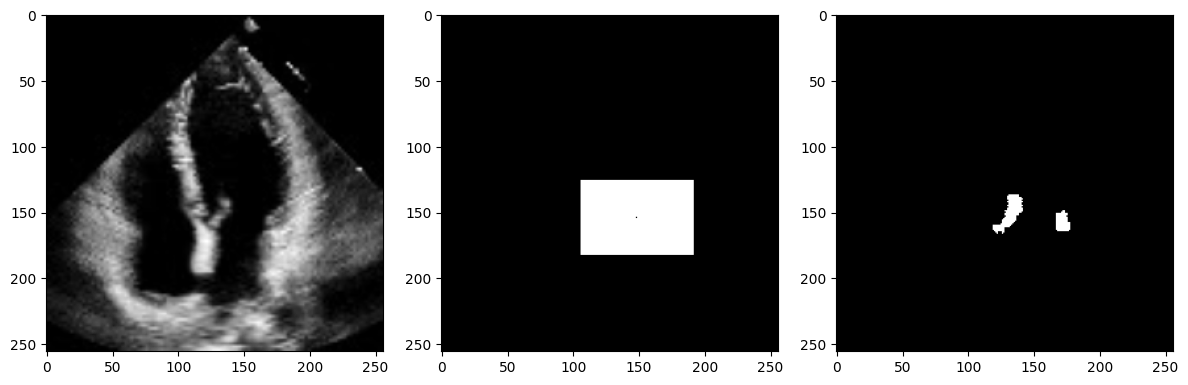

In [22]:
f = 100

frame_f = all_train_dataset.frames_data[f]
box_f = all_train_dataset.boxes_data[f]
label_f = all_train_dataset.labels_data[f]

center_x, center_y = all_train_dataset.centers_data[f]
center_x, center_y = center_x.astype(int), center_y.astype(int)
box_f[center_x][center_y] = False

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(frame_f, cmap='gray')
axs[1].imshow(box_f, cmap='gray')
axs[2].imshow(label_f, cmap='gray')

    
plt.tight_layout()
plt.show()

## Models

In [31]:
class BoxModel(nn.Module):
    def __init__(self):
        super(BoxModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # (batch_size, 16, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 16, 128, 128)
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (batch_size, 32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (batch_size, 64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 64, 32, 32)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 512),  # Reduced number of neurons
            nn.ReLU(),
            #nn.Dropout(0.1),  # Optional regularization
            nn.Linear(512, 2)  # Output x, y coordinates
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [27]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()

        # Encoder (Downsampling path)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Upsampling path)
        self.upconv4 = self.upconv_block(1024, 512)
        self.dec4 = self.conv_block(1024, 512)  # 512 (up) + 512 (cropped encoder)

        self.upconv3 = self.upconv_block(512, 256)
        self.dec3 = self.conv_block(512, 256)  # 256 (up) + 256 (cropped encoder)

        self.upconv2 = self.upconv_block(256, 128)
        self.dec2 = self.conv_block(256, 128)  # 128 (up) + 128 (cropped encoder)

        self.upconv1 = self.upconv_block(128, 64)
        self.dec1 = self.conv_block(128, 64)   # 64 (up) + 64 (cropped encoder)

        # Output layer with target size (N, 1, 96, 96)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block with Conv2D + BatchNorm + ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """Upsampling block with ConvTranspose2D"""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def crop_and_concat(self, encoder_features, decoder_features):
        """Crop encoder features to match decoder dimensions and concatenate"""
        _, _, H, W = decoder_features.size()
        _, _, H_enc, W_enc = encoder_features.size()
        crop_h = (H_enc - H) // 2
        crop_w = (W_enc - W) // 2
        enc_cropped = encoder_features[:, :, crop_h:crop_h+H, crop_w:crop_w+W]
        return torch.cat([enc_cropped, decoder_features], dim=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                           # (N, 64, 256, 256)
        enc2 = self.enc2(F.max_pool2d(enc1, 2, 2))    # (N, 128, 128, 128)
        enc3 = self.enc3(F.max_pool2d(enc2, 2, 2))    # (N, 256, 64, 64)
        enc4 = self.enc4(F.max_pool2d(enc3, 2, 2))    # (N, 512, 32, 32)

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2, 2))  # (N, 1024, 16, 16)

        # Decoder
        up4 = self.upconv4(bottleneck)                # (N, 512, 32, 32)
        dec4 = self.dec4(self.crop_and_concat(enc4, up4))  # (N, 512, 32, 32)

        up3 = self.upconv3(dec4)                      # (N, 256, 64, 64)
        dec3 = self.dec3(self.crop_and_concat(enc3, up3))  # (N, 256, 64, 64)

        up2 = self.upconv2(dec3)                      # (N, 128, 128, 128)
        dec2 = self.dec2(self.crop_and_concat(enc2, up2))  # (N, 128, 128, 128)

        up1 = self.upconv1(dec2)                      # (N, 64, 256, 256)
        dec1 = self.dec1(self.crop_and_concat(enc1, up1))  # (N, 64, 256, 256)

        # Output
        out = self.out_conv(dec1)                     # (N, 1, 256, 256)
        out = F.interpolate(out, size=(96, 96), mode='bilinear', align_corners=False)
        return torch.sigmoid(out)  # Final shape: (N, 1, 96, 96)

## Train Box finding

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_train_dataset.box = True
train_loader = DataLoader(all_train_dataset, batch_size=16, shuffle=True)

box_model = BoxModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(box_model.parameters(), lr=0.001)
losses = []

# Training loop
def train_model(train_loader, model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for frame_batch, center_batch in train_loader: # images: (batch_size, 1, 256, 256), targets: (batch_size, 4)
            optimizer.zero_grad()
            outputs = model(frame_batch.unsqueeze(1))
            loss = criterion(outputs, center_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss/len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

        
train_model(train_loader, box_model, criterion, optimizer, num_epochs=20)

Epoch 1/20, Loss: 11844.184478759766
Epoch 2/20, Loss: 942.7359478290265
Epoch 3/20, Loss: 501.7317903958834
Epoch 4/20, Loss: 347.49007709209735
Epoch 5/20, Loss: 300.5761225773738
Epoch 6/20, Loss: 222.09476177509015
Epoch 7/20, Loss: 199.06189727783203
Epoch 8/20, Loss: 177.42856003687933
Epoch 9/20, Loss: 132.3967153109037
Epoch 10/20, Loss: 124.0937517606295
Epoch 11/20, Loss: 85.36848567082332
Epoch 12/20, Loss: 57.77611585763785
Epoch 13/20, Loss: 47.847645686222954
Epoch 14/20, Loss: 27.341626827533428
Epoch 15/20, Loss: 18.09743960087116
Epoch 16/20, Loss: 18.004768114823563
Epoch 17/20, Loss: 9.02957505446214
Epoch 18/20, Loss: 6.440725730015681
Epoch 19/20, Loss: 4.751196384429932
Epoch 20/20, Loss: 3.039401100232051


In [37]:
torch.save(box_model, "models/box_model.pth")
test_model = torch.load("models/box_model.pth")
print(test_model)

BoxModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)


C:\Users\marti\AppData\Local\Temp\ipykernel_10556\2175834071.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load("models/box_model.pth")


## BoxModel Testing

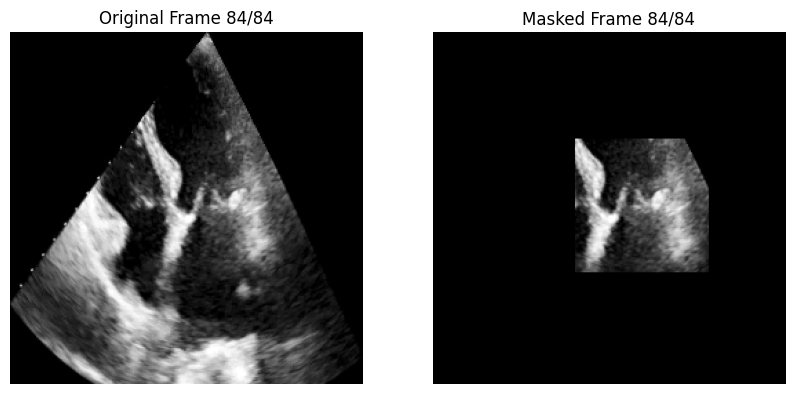

In [40]:
all_train_dataset.box = False

test_video = test_data[5]['video']
vid = np.zeros((256,256,test_video.shape[2]))
for i in range(test_video.shape[2]):
    vid[:,:,i] = cv2.resize(test_video_0[:,:,i].astype(np.uint8), (256, 256))
   

vid = torch.FloatTensor(vid)
frames = vid.unsqueeze(0)
frames = frames.permute(3, 0, 1, 2)
#print(frames.shape)


box_model.eval()
frame_box_coords = box_model(frames)
boxes = reconstruct_box_centers_batch(frame_box_coords)

video_frames = frames.squeeze().permute(1, 2, 0)
video_boxes = boxes.permute(1, 2, 0)
#print(video_frames.shape)
#print(video_boxes.shape)

show_video(frames=video_frames.detach().numpy(), masks=video_boxes.detach().numpy(), speed=0.0001)


## Homogenize Box size in datasets

In [43]:
def crop_frames_adjust_boxes_dataset(dataset):
    boxes = dataset.boxes_data
    new_boxes = []
    
    for i in range(len(boxes)):
        new_boxes.append(substitute_with_my_box(boxes[i]))
    
    new_boxes = np.array(new_boxes) 
    dataset.boxes_data = new_boxes
    
    frames = dataset.frames_data
    boxes = dataset.boxes_data
    cropped_frames = []
    
    for i in range(len(frames)):
        cropped_frames.append(get_cropped_frame(frames[i], boxes[i]))
        
    new_frames = np.array(cropped_frames)
    dataset.cropped_frames_data = new_frames
    
    labels = dataset.labels_data
    cropped_labels = []
    
    for i in range(len(labels)):
        cropped_labels.append(get_cropped_frame(labels[i], boxes[i]))
        
    new_labels = np.array(cropped_labels)
    dataset.cropped_labels_data = new_labels

        
        
crop_frames_adjust_boxes_dataset(amateur_train_dataset)
print("Adjusted the Amateur Set")
crop_frames_adjust_boxes_dataset(expert_train_dataset)
print("Adjusted the Expert Set")
crop_frames_adjust_boxes_dataset(all_train_dataset)
print("Adjusted the All Set")

Adjusted the Amateur Set
Adjusted the Expert Set
Adjusted the All Set


## Train UNET

In [64]:
unet_model = SimpleUNet()
optimizer_unet = torch.optim.Adam(unet_model.parameters(), lr=1e-4)

amateur_train_dataset.unet = True
train_loader_amateur = DataLoader(amateur_train_dataset, batch_size=16, shuffle=True)
num_epoch = 30

for epoch in range(num_epoch):
    unet_model.train()
    total_loss = 0

    for cropped_frame_batch, cropped_label_batch in train_loader_amateur:
        
        cropped_frame_batch, cropped_label_batch = cropped_frame_batch.to(device), cropped_label_batch.to(device)
        cropped_frame_batch = cropped_frame_batch.unsqueeze(1)
        optimizer_unet.zero_grad()
        
        preds = unet_model(cropped_frame_batch)
        preds = preds.squeeze()
    
        loss = F.binary_cross_entropy(preds, cropped_label_batch)

        loss.backward()
        optimizer_unet.step()
        
        total_loss += loss.item()    
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {total_loss/len(train_loader_amateur)}")

Epoch 1/30, Loss: 0.5357467201020982
Epoch 2/30, Loss: 0.4168384207619561
Epoch 3/30, Loss: 0.3395326965385013
Epoch 4/30, Loss: 0.29600584506988525
Epoch 5/30, Loss: 0.2718404134114583
Epoch 6/30, Loss: 0.2571355170673794
Epoch 7/30, Loss: 0.24570280975765652
Epoch 8/30, Loss: 0.23619401786062452
Epoch 9/30, Loss: 0.2286610553661982
Epoch 10/30, Loss: 0.22123649385240343
Epoch 11/30, Loss: 0.21475029322836134
Epoch 12/30, Loss: 0.20787303977542454
Epoch 13/30, Loss: 0.20240086317062378
Epoch 14/30, Loss: 0.19714762767155966
Epoch 15/30, Loss: 0.19244660271538627
Epoch 16/30, Loss: 0.18881209029091728
Epoch 17/30, Loss: 0.18514270252651638
Epoch 18/30, Loss: 0.18127199676301745
Epoch 19/30, Loss: 0.17711595859792498
Epoch 20/30, Loss: 0.1740728517373403
Epoch 21/30, Loss: 0.17068245344691807
Epoch 22/30, Loss: 0.16696455081303915
Epoch 23/30, Loss: 0.1637866066561805
Epoch 24/30, Loss: 0.161020095149676
Epoch 25/30, Loss: 0.15778339902559915
Epoch 26/30, Loss: 0.15537910163402557
Epoch

In [66]:
expert_train_dataset.unet = True
train_loader_expert = DataLoader(expert_train_dataset, batch_size=8, shuffle=True)
num_epoch = 20

for epoch in range(num_epoch):
    unet_model.train()
    total_loss = 0

    for cropped_frame_batch, cropped_label_batch in train_loader_expert:
        
        cropped_frame_batch, cropped_label_batch = cropped_frame_batch.to(device), cropped_label_batch.to(device)
        cropped_frame_batch = cropped_frame_batch.unsqueeze(1)
        optimizer_unet.zero_grad()
        
        preds = unet_model(cropped_frame_batch)
        preds = preds.squeeze()
    
        loss = F.binary_cross_entropy(preds, cropped_label_batch.squeeze())

        loss.backward()
        optimizer_unet.step()
        
        total_loss += loss.item()    
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {total_loss/len(train_loader_amateur)}")

Epoch 1/20, Loss: 0.23539202246401045
Epoch 2/20, Loss: 0.2271373470624288
Epoch 3/20, Loss: 0.20331037375662062
Epoch 4/20, Loss: 0.18050720791021982
Epoch 5/20, Loss: 0.1697606494029363
Epoch 6/20, Loss: 0.16318136122491625
Epoch 7/20, Loss: 0.1522089640299479
Epoch 8/20, Loss: 0.14689812560876211
Epoch 9/20, Loss: 0.14239624639352164
Epoch 10/20, Loss: 0.13954554994901022
Epoch 11/20, Loss: 0.13779401116900974
Epoch 12/20, Loss: 0.1350711699989107
Epoch 13/20, Loss: 0.13450566099749672
Epoch 14/20, Loss: 0.12951477037535775
Epoch 15/20, Loss: 0.12534447842174107
Epoch 16/20, Loss: 0.12356078624725342
Epoch 17/20, Loss: 0.12203268044524723
Epoch 18/20, Loss: 0.11859659850597382
Epoch 19/20, Loss: 0.11793098350365956
Epoch 20/20, Loss: 0.11852198508050707


In [68]:
torch.save(unet_model, "models/unet_model.pth")

## UNET testing

In [ ]:
test_video_0 = test_data[17]['video']
vid = np.zeros((256,256,test_video_0.shape[2]))
for i in range(test_video_0.shape[2]):
    vid[:,:,i] = cv2.resize(test_video_0[:,:,i].astype(np.uint8), (256, 256))
    
vid = vid[:,:,0:5]
vid = torch.FloatTensor(vid)
frames = vid.unsqueeze(0)
frames = frames.permute(3, 0, 1, 2)

box_model.eval()
frame_box_coords = box_model(frames)
frames = frames.squeeze()
boxes = reconstruct_box_centers_batch(frame_box_coords)

cropped_frames = []
for i in range(5):
    cropped_frames.append(get_cropped_frame(frames[i], boxes[i]))
    
cropped_frames = torch.FloatTensor(np.array(cropped_frames))
cropped_frames = cropped_frames.unsqueeze(1)


unet_model.eval()
segmented_cropped_frame = unet_model(cropped_frames)
#print("Segmented Cropped Frames shape:")
#print(segmented_cropped_frame.shape)

for i in range(1):
    abba = segmented_cropped_frame[i].squeeze().detach().numpy()
    abba = abba > 0.5

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot the frame without mask
    axs[0].imshow(cropped_frames[i,:,:].squeeze(), cmap='gray')
    title0 = "Cropped Frame"
    axs[0].set_title(title0)
    axs[0].axis('off')
    
    # Plot the frame with mask
    axs[1].imshow(abba, cmap='gray')
    title1 = "Cropped Segmented Frame"
    axs[1].set_title(title1)
    axs[1].axis('off') 
    
    plt.tight_layout()
    plt.show()

## Final Evaluation

In [ ]:
index = 0
item = test_data[index]
video = item['video']
original_height, original_width, _ = video.shape 

video = cv2.resize(video.astype(np.uint8), (256, 256))
video = video.transpose((2, 0, 1))
video = np.expand_dims(video, axis=1)
video = torch.FloatTensor(video)

box_model.eval()
video_centers = box_model(video)
boxes_video = reconstruct_box_centers_batch(video_centers)
video = video.squeeze()

cropped_frames = []
for i in range(video.shape[0]):
    cropped_frames.append(get_cropped_frame(video[i,:,:], boxes_video[i,:,:]))

cropped_video = torch.FloatTensor(np.array(cropped_frames))
cropped_video = cropped_video.unsqueeze(1)

unet_model.eval()
segmented_cropped_video = unet_model(cropped_video)
segmented_cropped_video = segmented_cropped_video.squeeze()

segmented_video = decrop_video(segmented_cropped_video, video_centers)

#Resize to original shape
final_video = []
for i in range(video.shape[0]):
    final_frame = resize_boolean_array(segmented_video[i,:,:], (original_height, original_width))
    final_video.append(final_frame)
final_video = np.array(final_video)


print(final_video.shape)
segmented_videos.append(final_video)

In [ ]:
plt.figure(figsize=(10, 10))
index = 0
video = final_video
num_frames = video.shape[0]
    
for i in range(num_frames):
    plt.clf()  
    plt.imshow(test_data[index]['video'][:,:,i], cmap='gray')
    plt.imshow(video[i, :, :], cmap="Reds", alpha=0.5)
    plt.axis('off')
    plt.title(f"Frame {i+1}/{num_frames}")

    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.001)

## Smoothing 

In [ ]:
from scipy.ndimage import gaussian_filter, median_filter

def smooth_video(noisy_video):
    noisy_video = noisy_video.transpose((2, 0, 1))
    smoothed_video = gaussian_filter(noisy_video, sigma=(1, 1, 1))
    smoothed_video = smoothed_video.transpose((1, 2, 0))
    return smoothed_video

smoothed_video = smooth_video(test_data[index]['video'])

for i in range(num_frames):
    plt.clf()  # Clear the previous plot

    # Left subplot: Original video
    plt.imshow(smoothed_video[:,:,i], cmap='gray')
    plt.axis('off')
    plt.title(f"Frame {i+1}/{num_frames}")

    # Display and wait
    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.001)